In [1]:
#### FINAL VERSION ####


from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from utils import setup_data
from setup_model import get_models 
from datasetlite import DataLoaderLite 


import math 
import torch 


#----- Model Setup -------

TrainingConfig, encoder_model, decoder_model , pad_token_id, tokenizer = get_models() 

# torch.mps.empty_cache()
# import gc; gc.collect()



def collate_fn(batch):
    images, input_ids, attention_mask = zip(*batch)
    images = torch.stack(images)
    # pad input_ids and attention_mask to the max length in this batch
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    return images, input_ids, attention_mask


train_dataset_cocooptions, val_dataset_cocooptions, train_dataset_detection , val_dataset_detection = setup_data(TrainingConfig.number_of_items)
train_dataset_cocooptions = DataLoaderLite(train_dataset_cocooptions, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)
val_dataset_cocooptions = DataLoaderLite(val_dataset_cocooptions, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=False)


total_steps = len(train_dataloader)  * TrainingConfig.epochs
formatted_str = f"Training details vocab size {TrainingConfig.vocab_size} batch size {TrainingConfig.batch_size} image size {TrainingConfig.image_h}x{TrainingConfig.image_w}"
formatted_str+= f" total steps {total_steps} epochs {TrainingConfig.epochs}"
formatted_str+= f"Max loss {math.log(TrainingConfig.vocab_size)}"
formatted_str+= f"Perplexity {math.exp(math.log(TrainingConfig.vocab_size))}"

print (formatted_str)


/Users/preetamverma/Desktop/multimodel/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Trainable parameters in  model:
165892096
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=3.73s)
creating index...
index created!
Training details vocab size 50259 batch size 4 image size 224x224 total steps 1000 epochs 1Max loss 10.824944914361643Perplexity 50259.00000000004


In [2]:
#### TRAINING LOOP #####


from torch.cuda.amp import GradScaler

import numpy as np 
from utils import calculate_total_train_params, save_to_checkpoint
import torch.nn as nn 



scaler = GradScaler()

loss_list = []


def eval():
    # --------------------
    #  Validation step
    # --------------------
    decoder_model.eval()
    encoder_model.eval()
    val_loss = 0
    count = 0 
    with torch.no_grad():
        for val_batch in val_dataloader:
            image_tensor, caption_tensor, attention_mask = [x.to(device) for x in val_batch]
            with torch.autocast("mps", enabled=True, dtype=torch.bfloat16):
                x_embed = encoder_model(image_tensor)
                _, val_caption_loss = decoder_model(x_embed, caption_tensor, attention_mask)
            val_loss += val_caption_loss.item()
            count+=1
            if count > 2:break 
    val_loss /= count 
    decoder_model.train()
    encoder_model.train()
    print(f"Epoch {epoch+1}: train_loss={total_loss/len(train_dataloader):.4f}, val_loss={val_loss:.4f}")
    return val_loss 



def should_stop(loss_list):
    last_ten_loss = loss_list[-100:]
    threshold = 0.4
    if len(last_ten_loss)==100 and len(loss_list)>=100:
        diffs = np.diff(last_ten_loss)
        step_trends = []
        for d in diffs:
            if d > threshold:
                step_trends.append("increasing")
            elif d < -threshold:
                step_trends.append("decreasing")
            else:
                step_trends.append("steady")

        if all(t == "steady" for t in step_trends):
            return True 
        else:
            print ("Trend", step_trends)
    return False 



##### Setup Training #####
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id)
all_params = calculate_total_train_params(encoder_model, decoder_model)


print (f"Trainable parameters in encoder model: {sum(p.numel() for p in all_params if p.requires_grad)/1e6} M")

optimizer = torch.optim.AdamW(all_params, lr=TrainingConfig.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps/TrainingConfig.accumulation_steps, eta_min=1e-6)

import time 
start_time = time.time()
total_loss = 0 
best_val_loss = float("inf")
epochs_no_improve = 0
steps_no_improve = 0
patience_steps = 10
stop = False 
device = torch.device("mps")


for epoch in range(TrainingConfig.epochs):
    for step, batch in enumerate(train_dataloader):
        image_tensor, caption_tensor, attention_mask = batch[0], batch[1], batch[2] # [B, 3, 224, 224], [B, T], [B, T] 
        image_tensor, caption_tensor, attention_mask = image_tensor.to(device), caption_tensor.to(device), attention_mask.to(device)
        B, C, H, W = image_tensor.shape

        global_step = epoch * len(train_dataloader) + step + 1     

        with torch.autocast("mps", enabled=True, dtype=torch.bfloat16):
            x_embed = encoder_model(image_tensor) # (B, N, embed_size) 
            logits, caption_loss  = decoder_model(x_embed, caption_tensor, attention_mask)  # (B, T-1, vocab_size)

            loss = caption_loss / TrainingConfig.accumulation_steps  

        # x_embed = image_encoder(image_tensor) # (B, N, embed_size) 
        # logits, caption_loss  = caption_encoder(x_embed, caption_tensor, attention_mask)  # (B, T-1, vocab_size)
        # loss = caption_loss / TrainingConfig.accumulation_steps  


        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(all_params, max_norm=5.0)
        if (step + 1) % TrainingConfig.accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        total_loss += loss.item() * TrainingConfig.accumulation_steps  


        if global_step %100==0:
            val_loss = eval()
            loss_list.append(val_loss)
            save_to_checkpoint(encoder_model, decoder_model, optimizer, epoch, loss, global_step)

            if should_stop(loss_list):
                stop = True 
                break

          # estimate remaining time every 100 steps
        if global_step % 100 == 0:
            elapsed = time.time() - start_time
            steps_per_sec = global_step / elapsed
            remaining_steps = total_steps - global_step
            est_remaining = remaining_steps / steps_per_sec
            est_total = total_steps / steps_per_sec

            print(f"epoch {epoch+1}/{TrainingConfig.epochs} step {step}/{len(train_dataloader)} "
                  f"Loss: {loss.item()*TrainingConfig.accumulation_steps:.4f} | "
                  f"Elapsed: {elapsed/60:.2f} min | "
                  f"ETA: {est_remaining/60:.2f} min | "
                  f"Total est: {est_total/60:.2f} min | "
                  f"Memory: {torch.mps.current_allocated_memory() / 1e9:.2f} GB , \ {torch.mps.driver_allocated_memory() / 1e9:.2f} GB | "
                  f"Perplexity {math.exp(loss.item()*TrainingConfig.accumulation_steps):.2f}"
                  )
            
            # save_model(image_encoder=image_encoder, caption_encoder=caption_encoder)

    if (step + 1) % TrainingConfig.accumulation_steps != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(all_params, 5.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    if stop:
        save_to_checkpoint(encoder_model, decoder_model, optimizer, epoch, loss, global_step)
        break
    
    del image_tensor, caption_tensor, x_embed, logits
    torch.mps.empty_cache()
    import gc; gc.collect()

<>:138: SyntaxWarning: invalid escape sequence '\ '
<>:138: SyntaxWarning: invalid escape sequence '\ '
/var/folders/ww/qr_kh7fj37j544l07ttgdbfm0000gn/T/ipykernel_70025/3394569368.py:138: SyntaxWarning: invalid escape sequence '\ '
  f"Memory: {torch.mps.current_allocated_memory() / 1e9:.2f} GB , \ {torch.mps.driver_allocated_memory() / 1e9:.2f} GB | "
/var/folders/ww/qr_kh7fj37j544l07ttgdbfm0000gn/T/ipykernel_70025/3394569368.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/preetamverma/Desktop/multimodel/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Trainable parameters in encoder model: 165.892096 M
Epoch 1: train_loss=1.3183, val_loss=9.8120
 SAVING INTO CHECKPOINT at global step 100 and loss 2.6054909229278564
epoch 1/1 step 99/1000 Loss: 10.4220 | Elapsed: 0.41 min | ETA: 3.66 min | Total est: 4.07 min | Memory: 3.90 GB , \ 8.12 GB | Perplexity 33589.33
Epoch 1: train_loss=2.1837, val_loss=7.5796
 SAVING INTO CHECKPOINT at global step 200 and loss 1.862675428390503
epoch 1/1 step 199/1000 Loss: 7.4507 | Elapsed: 0.81 min | ETA: 3.23 min | Total est: 4.04 min | Memory: 3.90 GB , \ 8.12 GB | Perplexity 1721.07
Epoch 1: train_loss=2.7759, val_loss=3.7621
 SAVING INTO CHECKPOINT at global step 300 and loss 1.0258718729019165
epoch 1/1 step 299/1000 Loss: 4.1035 | Elapsed: 1.21 min | ETA: 2.82 min | Total est: 4.02 min | Memory: 3.90 GB , \ 8.12 GB | Perplexity 60.55
Epoch 1: train_loss=3.1400, val_loss=3.4563
 SAVING INTO CHECKPOINT at global step 400 and loss 0.8470010757446289
epoch 1/1 step 399/1000 Loss: 3.3880 | Elapsed: 1.61

In [3]:
! export PYTORCH_ENABLE_MPS_FALLBACK=1 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [4]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from utils import setup_data
from setup_model import get_models 
from datasetlite import DataLoaderLite 


import math 
import torch 


#----- Model Setup -------

tup = get_models() 

TrainingConfig, tokenizer = tup[0], tup[-1]

torch.mps.empty_cache()
import gc; gc.collect()



def collate_fn(batch):
    images, input_ids, attention_mask = zip(*batch)
    images = torch.stack(images)
    # pad input_ids and attention_mask to the max length in this batch
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    return images, input_ids, attention_mask


train_dataset_cocooptions, val_dataset_cocooptions, train_dataset_detection , val_dataset_detection = setup_data(TrainingConfig.number_of_items)
train_dataset_cocooptions = DataLoaderLite(train_dataset_cocooptions, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)
val_dataset_cocooptions = DataLoaderLite(val_dataset_cocooptions, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=False)


total_steps = len(train_dataloader)  * TrainingConfig.epochs
formatted_str = f"Training details vocab size {TrainingConfig.vocab_size} batch size {TrainingConfig.batch_size} image size {TrainingConfig.image_h}x{TrainingConfig.image_w}"
formatted_str+= f" total steps {total_steps} epochs {TrainingConfig.epochs}"
formatted_str+= f"Max loss {math.log(TrainingConfig.vocab_size)}"
formatted_str+= f"Perplexity {math.exp(math.log(TrainingConfig.vocab_size))}"

print (formatted_str)


Trainable parameters in  model:
165892096
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=4.07s)
creating index...
index created!
Training details vocab size 50259 batch size 4 image size 224x224 total steps 1000 epochs 1Max loss 10.824944914361643Perplexity 50259.00000000004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7890625..2.140625].


With image context:	 	  " a more one m( of is the a and F.(
------
Actual		  The man is riding his surfboard with a stuffed animal. 


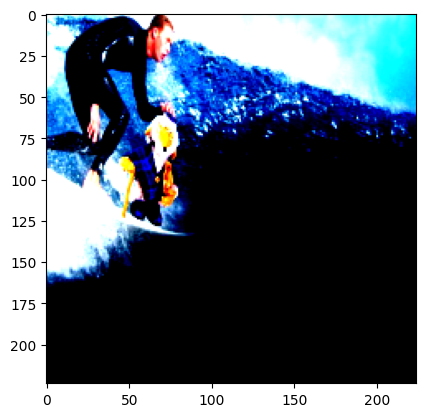

In [ ]:
from torch.nn import functional as F

import matplotlib.pyplot as plt 
from transformers.generation.logits_process import LogitsProcessorList
from transformers import LogitsProcessorList, MinLengthLogitsProcessor, RepetitionPenaltyLogitsProcessor

from transformers.generation.logits_process import (
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
)

# Chain multiple warpers
warpers = LogitsProcessorList([
    TemperatureLogitsWarper(0.8),
    TopKLogitsWarper(50),
    TopPLogitsWarper(0.95),
])

processors = LogitsProcessorList([
    RepetitionPenaltyLogitsProcessor(penalty=1.2)
])

from utils import load_from_checkpoint 

encoder, decoder , epoch, loss , global_step, tokenizer = load_from_checkpoint()




device = torch.device("mps")

def generate_caption(image_tensor, max_len=20, use_image=True):
    encoder.eval()
    decoder.eval()

    image_tensor = image_tensor.to(device).unsqueeze(0)

    x_embed = encoder(image_tensor) 

    start_id = tokenizer.convert_tokens_to_ids("<START>")
    generated_ids = torch.tensor([[start_id]], device=device)

    for _ in range(max_len):
        with torch.no_grad():
            attn_mask = torch.ones(1, generated_ids.shape[1], dtype=torch.bfloat16, device=device)

            logits, _ = decoder(x_embed, generated_ids, attn_mask, mode="train")

            next_logits = logits[:, -1, :]

            next_logits = next_logits.to(torch.bfloat16)

            next_logits = processors(generated_ids.cpu(), next_logits.cpu())

            next_logits = warpers(None, next_logits.cpu())

            probs = F.softmax(next_logits, dim=-1)
        
            # Sample on CPU to avoid MPS issues
            next_token_id = torch.multinomial(probs, num_samples=1).to(device)


        generated_ids = torch.cat([generated_ids, next_token_id], dim=1)

        if next_token_id.item() == tokenizer.convert_tokens_to_ids("<END>"):
            break

    caption = tokenizer.decode(generated_ids.squeeze().tolist(), skip_special_tokens=True)

    return caption


counter = 0 
# Example usage
for step, batch in enumerate(train_dataloader):
    image_tensor, caption_tensor, attention_mask = batch[0], batch[1], batch[2] # [B, 3, 224, 224], [B, T], [B, T] 
    image_tensor, caption_tensor, attention_mask = image_tensor.to(device), caption_tensor.to(device), attention_mask.to(device)
    B, C, H, W = image_tensor.shape

    #caption_without_image = generate_caption(encoder_model, caption_encoder, image_tensor[0], tokenizer, use_image=False)

    caption_with_image = generate_caption(image_tensor[0], use_image=True)

    plt.imshow(image_tensor[0].float().permute(1,2,0).cpu().numpy())
    print("With image context:\t \t", caption_with_image)
    print ("Actual\t\t", tokenizer.decode(caption_tensor[0].tolist(), skip_special_tokens=True))
    # print("Without image context: ", caption_without_image)
    break

